<h1><strong><u>Naive Bayes Test (A4)</u></strong><h1>

In [12]:
%%capture
%run DataPrep.ipynb

<h2><strong><u>Bayesian Model Selection</u></strong><h2>

<h3><strong><u>Validation Curve Tests</u></strong></h3>

In [13]:
for title, metric in clf_metrics.items():
    pipeline = ImbLearn_Pipeline(
        [
            ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
            ("samp", SMOTE(random_state=3)),
            ("clf", MultinomialNB())
        ]
    ) 

    alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring=metric,
                                                    param_name="clf__alpha",
                                                    param_range=alphas,
                                                    n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    vc_plot_dict[f"Logistic Regession: {title} VC"] = [alphas, 
                                                    [train_scores_mean, validation_scores_mean], 
                                                    ["Regularization Coefficient", title]]

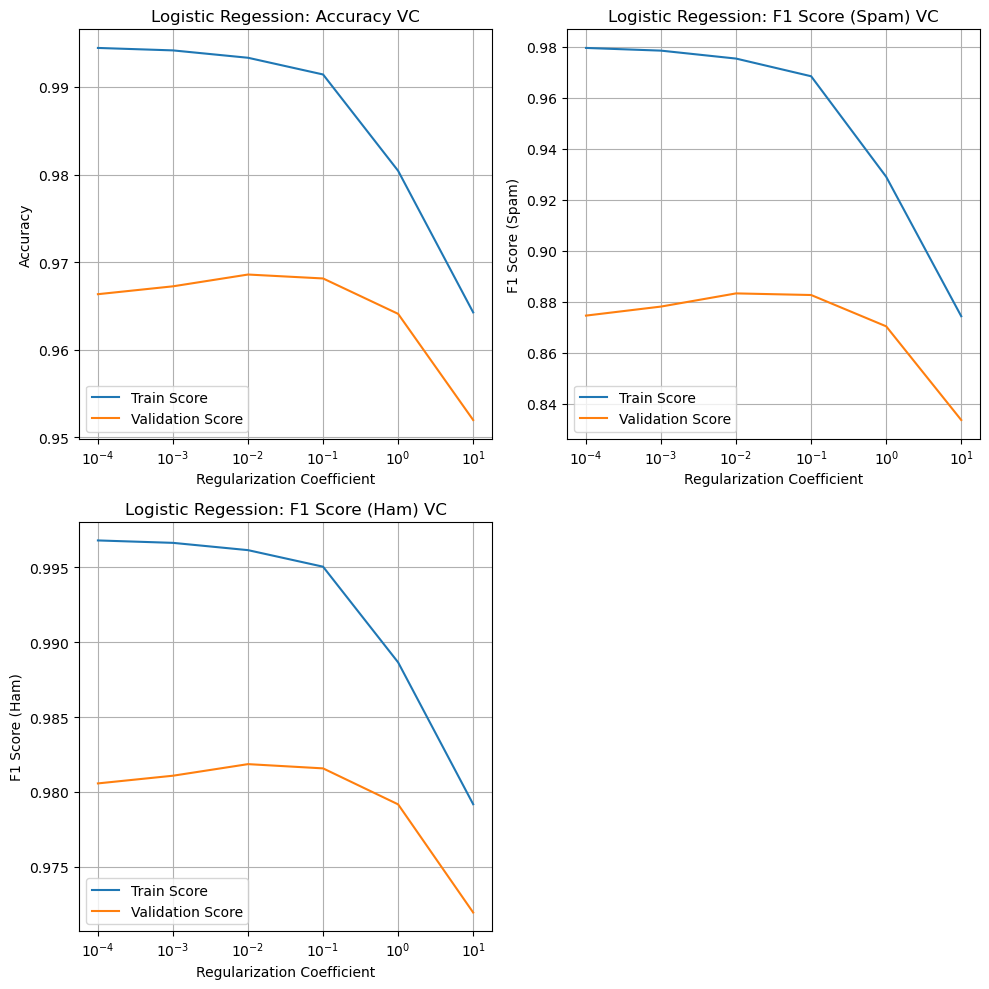

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in vc_plot_dict.items():
    axs[count].semilogx(value[0], value[1][0], label="Train Score")
    axs[count].semilogx(value[0], value[1][1],  label="Validation Score")
    axs[count].set_xlabel(value[2][0])
    axs[count].set_ylabel(value[2][1])
    axs[count].set_title(key)
    axs[count].grid()
    axs[count].minorticks_off()
    axs[count].legend()
    count += 1

# Delete the unused subplot (e.g., the last one for a 3x2 grid with 5 plots)
fig.delaxes(axs[count]) 

plt.tight_layout()
plt.show()

<h3><strong><u>Cross-Validation Test</u></strong></h3>

In [4]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=3)),
        ("clf", MultinomialNB())
    ]
) 
param_grid = {"clf__alpha": [0.1, 0.3, 0.5, 0.7, 0.9, 1]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=custom_f1_scorer_spam)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
nb_model = grid_search.best_estimator_

def nb_spam_classifier():
    return nb_model

Best Parameters:  {'clf__alpha': 0.1}


<h4><strong><u>Findings From 'Model Selection' Section</u></strong></h4>
The scoring metrics that I used for the Grid Search cross-validation test was the f1 score. F1 score is a good method to access the model's performance on the 'positive' class; spam in this instance; especially for imbalanced dataset or even datasets that have been synthetically balanced like this one. Switching between the RandomUnderSampler function and SMOTE while using a logarithmic range of regularization coefficients, I found that SMOTE performed better than the RandomUnderSampling function on the f1 scores. For the regularization coefficient, I found that the best regularization coefficient will mostly likely be 0.1. Therefore, I used a small range of regularization coefficients that included 0.1 for the Grid Search cross-validation test.

<h2><strong><u>Model Evaluation</u></strong></h2>

<h3><strong><u>Learning Curve Tests</u></strong></h3>

In [5]:
for key, value in clf_metrics.items():
    bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
        nb_model,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
    bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
    bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
    bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

    # Calculate spread of data around the mean
    bayesian_train_range_minus = bayesian_train_scores_mean - bayesian_train_scores_std
    bayesian_train_range_plus = bayesian_train_scores_mean + bayesian_train_scores_std
    bayesian_validation_range_minus = bayesian_validation_scores_mean - bayesian_validation_scores_std
    bayesian_validation_range_plus = bayesian_validation_scores_mean + bayesian_validation_scores_std

    lc_dict[key] = [[bayesian_train_scores_mean, bayesian_validation_scores_mean],
                    [bayesian_train_range_minus, bayesian_train_range_plus], 
                    [bayesian_validation_range_minus, bayesian_validation_range_plus], 
                    bayesian_train_sizes]

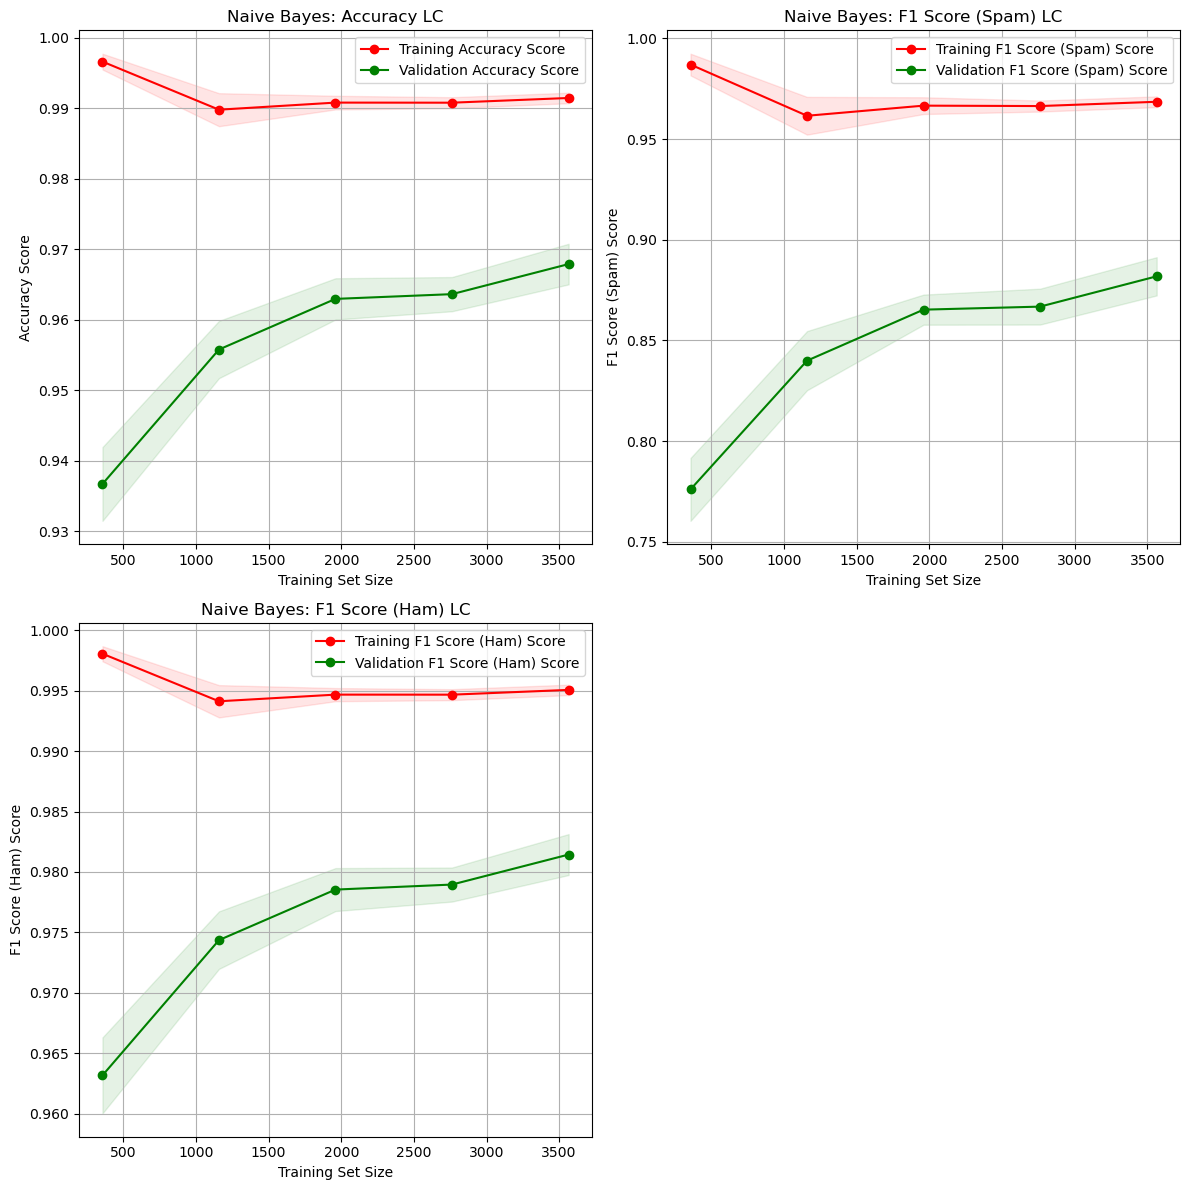

In [6]:
# Plot the learning curves
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in lc_dict.items():
    axs[count].set_title(f"Naive Bayes: {key} LC")
    axs[count].set_xlabel("Training Set Size")
    axs[count].set_ylabel(f"{key} Score")
    axs[count].grid()

    axs[count].fill_between(value[3], value[1][0], value[1][1], alpha=0.1, color="r")
    axs[count].fill_between(value[3], value[2][0], value[2][1], alpha=0.1, color="g")
    axs[count].plot(value[3], value[0][0], 'o-', color="r", label=f"Training {key} Score")
    axs[count].plot(value[3], value[0][1], 'o-', color="g", label=f"Validation {key} Score")
    axs[count].legend(loc="best")
    count += 1
    
fig.delaxes(axs[count]) 

plt.tight_layout()
plt.show()

<h3><strong><u>Evaluation Metrics</u></strong></h3>

In [7]:
for key, value in clf_metrics.items():
    print(f"{key}")
    nb_training_values = cross_val_score(nb_model, X_train, y=y_train, scoring=value, cv=5)
    print("CV Training Scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(f"Training Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV Training Scores:  [0.96412556 0.96748879 0.9674523  0.96857464 0.97306397]
Training Average and Standard Error:  0.97% ± 0.29% 

F1 Score (Spam)
CV Training Scores:  [0.86885246 0.88259109 0.88065844 0.88235294 0.89830508]
Training Average and Standard Error:  0.88% ± 0.94% 

F1 Score (Ham)
CV Training Scores:  [0.97922078 0.98113208 0.9811566  0.98186528 0.98447607]
Training Average and Standard Error:  0.98% ± 0.17% 



Text(0.5, 1.0, 'Naive Bayes: Confusion Matrix (Evaluation)')

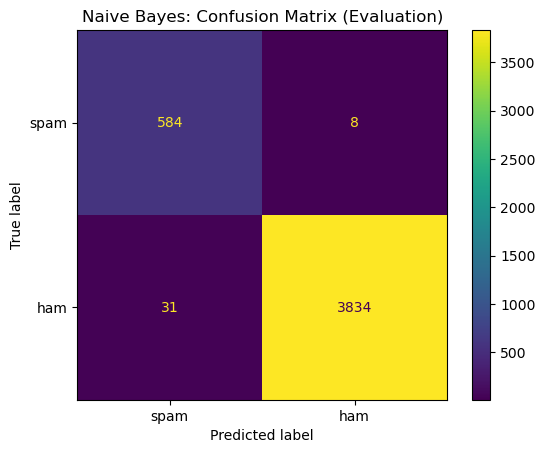

In [8]:
#Training Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(estimator=nb_model, X=X_train, y=y_train, labels=['spam', 'ham'])
disp.ax_.set_title("Naive Bayes: Confusion Matrix (Evaluation)")

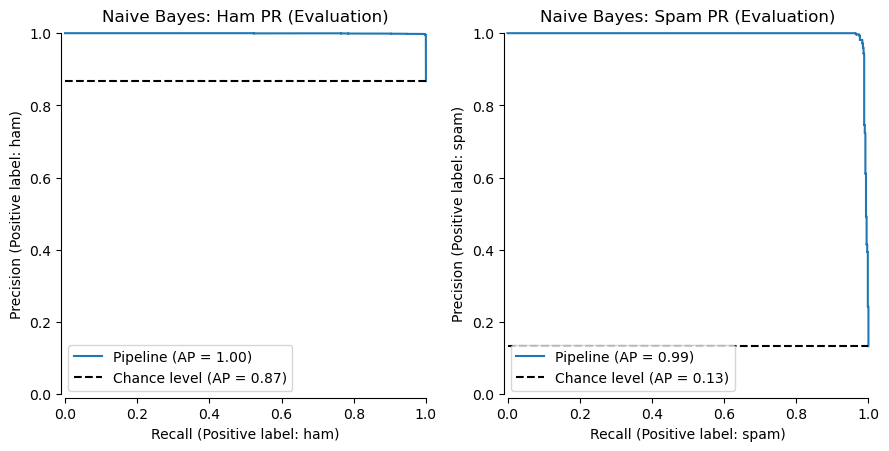

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(9, 9))
axs = axs.flatten()
count = 0
for label in train_labels:
    disp = PrecisionRecallDisplay.from_estimator(nb_model, X_train, y_train, ax=axs[count], pos_label=label, plot_chance_level=True, despine=True)
    disp.ax_.set_title(f"Naive Bayes: {label.capitalize()} PR (Evaluation)")
    count += 1

plt.tight_layout()  
plt.show()

<h4><strong><u>Findings From 'Model Evaluation' Phase</u></strong></h4>
In the evaluation of my selected Naive Bayes model, I found positive results for all evaluation methods. The learning curves yielded good results. This is very crucial since the original dataset was inbalanced in favor of 'ham' messages. Therefore, the 'F1 (Spam)' learning curve shows me that if more 'spam' data points are provided, then the model will be able to learn from them. Also, the 'cross_val_score' function evaluation results were in keeping with the learning curve results. In addition, the Confusion Matrix shows that the model performed well on the training data with minimal False Negatives and False Positives. Finally, The Precision-Recall plots display a good curve that moves to the top-right corner of the plot indicating a good classifier model. As a result, I will move forward with this model to the 'Final Model Testing' section.